In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os 

from skimage import measure

In [2]:
def mask(img_raw,thres=20,left=0,right=0,upper=0,lower=0):
    """根据特定阈值, 对原始图像进行二值化.
    """
    img_gray = cv2.cvtColor(img_raw, cv2.COLOR_BGR2GRAY)
    # 灰度化处理
    _, img_masked = cv2.threshold(img_gray, thres, 1,cv2.THRESH_BINARY)
    # 生成掩码
    img_masked[0:upper,:] = 0
    img_masked[(img_masked.shape[0]-lower):img_masked.shape[0],:] = 0
    img_masked[:,0:left] = 0
    img_masked[:,(img_masked.shape[1]-right):img_masked.shape[1]] = 0
    # 从四个方向将干扰信息置零
    return img_masked

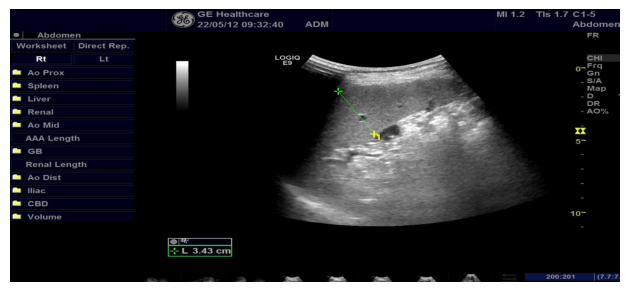

In [3]:
img_raw = cv2.imread('UBAO_example_1.jpg')
plt.imshow(img_raw[:, :, ::-1])
plt.axis('off')
plt.tight_layout()

In [4]:
img_raw.shape

(835, 1866, 3)

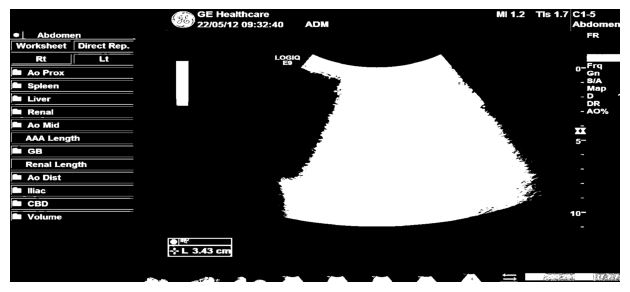

In [5]:
img_masked = mask(img_raw)
plt.imshow(img_masked,cmap = 'gray')
plt.axis('off')
plt.tight_layout()

In [6]:
def remove_small_points(img,threshold_size,threshold_point):
    img_label = measure.label(img, connectivity = True)#输出二值图像中所有的连通域
    props = measure.regionprops(img_label)#输出连通域的属性，包括面积等
    print(props[0].bbox)
 
    resMatrix = np.zeros(img_label.shape)
    for i in range(0, len(props)):
        if (props[i].bbox[2]-props[i].bbox[0]) > threshold_size[0] or (props[i].bbox[3]-props[i].bbox[1]) > threshold_size[1]:
            if (props[i].area>threshold_point):
                tmp = (img_label == i + 1).astype(np.uint8)
                resMatrix += tmp #组合所有符合条件的连通域
    resMatrix = resMatrix.astype(np.uint8)
    return resMatrix


In [7]:
def rect_removed(img):
    print(img.shape)
    contours,hierarchy = cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)  #寻找轮廓点
    for obj in contours:

        area = cv2.contourArea(obj)  #计算轮廓内区域的面积
        # cv2.drawContours(img, obj, -1, (255, 0, 0), 4)  #绘制轮廓线
        perimeter = cv2.arcLength(obj,True)  #计算轮廓周长
        approx = cv2.approxPolyDP(obj,0.02*perimeter,True)  #获取轮廓角点坐标
        CornerNum = len(approx)   #轮廓角点的数量

        if CornerNum == 4: 
            dx = (np.sort(approx[:,0,0])[1]-np.sort(approx[:,0,0])[0]+np.sort(approx[:,0,0])[3]-np.sort(approx[:,0,0])[2])
            dy = (np.sort(approx[:,0,1])[1]-np.sort(approx[:,0,1])[0]+np.sort(approx[:,0,1])[3]-np.sort(approx[:,0,1])[2])
            # print(dx,dy)
            if dx+dy<32:
                upper_fin = np.min(approx[:,0,1])-4 if np.min(approx[:,0,1])-4>0 else 0
                left_fin = np.min(approx[:,0,0])-4 if np.min(approx[:,0,0])-4>0 else 0
                lower_fin = np.max(approx[:,0,1])+4 if np.max(approx[:,0,1])+4<img.shape[0] else img.shape[0]
                right_fin = np.max(approx[:,0,0])+4 if np.max(approx[:,0,0])+4<img.shape[1] else img.shape[1]
                img[upper_fin:lower_fin,left_fin:right_fin] = 0
    return img

(0, 1715, 68, 1716)
(835, 1866)


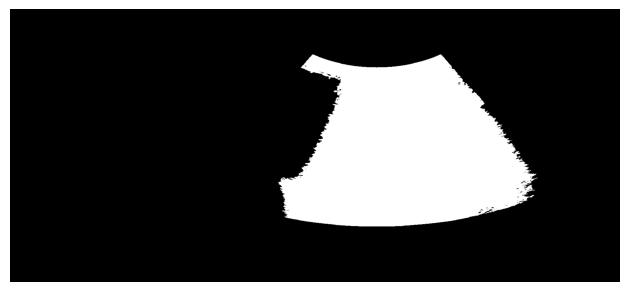

In [8]:
img_small_removed = remove_small_points(img_masked,(img_masked.shape[0]/10,img_masked.shape[1]/10),img_masked.shape[0]*img_masked.shape[1]/900)
img_rect_removed =rect_removed(img_small_removed)
plt.imshow(img_rect_removed,cmap='gray')
plt.axis('off')
plt.tight_layout()

In [9]:
def point_search(img_rect_removed):
    """KPS中的点搜寻, 寻找左右两侧边界与上侧边界的交点.

    Args:
        img_rect_removed (np.array):  扇面区域孔洞填充后的掩码图像.

    Returns:
        left_top_point (np.array): 左侧与上侧边界的交点.
        right_top_point (np.array): 右侧与上侧边界的交点.
    """
    row_begin_list = []
    row_end_list = []
    row_len_list = []
    for i in range(img_rect_removed.shape[0]):
        for j in range(len(img_rect_removed[i,:])-1):
            if img_rect_removed[i,j] == 1:
                break
        if img_rect_removed[i,j] == 1:
            break
    temp_i = i
    temp_j = j
    # print(i,j)
    for i in range(temp_i,img_rect_removed.shape[0]):
        for j in range(len(img_rect_removed[i,:])-1):
            if img_rect_removed[i,j] == 1 and np.abs(j-temp_j)>20:
                break
        if img_rect_removed[i,j] == 1 and np.abs(j-temp_j)>20:
            break
    # print(i,j)
    if j>temp_j:
        left_top_point = np.array((round((i+temp_i)/2),temp_j))
        right_top_point = np.array((round((i+temp_i)/2),j))
    else:
        left_top_point = np.array((round((i+temp_i)/2),j))
        right_top_point = np.array((round((i+temp_i)/2),temp_j))
    # print(left_top_point,right_top_point)

    return left_top_point,right_top_point

In [10]:
left_top_point,right_top_point = point_search(img_rect_removed)
left_top_point,right_top_point

(array([139, 925]), array([ 139, 1315]))

In [11]:
def side_search(img_rect_removed,left_top_point,right_top_point):
    coor = np.where(img_rect_removed>0)
    left_idx = np.argmin(coor[1])
    right_idx = np.argmax(coor[1])

    left_line_k =(left_top_point[0]-coor[0][left_idx])/(left_top_point[1]-coor[1][left_idx])
    right_line_k =(right_top_point[0]-coor[0][right_idx])/(right_top_point[1]-coor[1][right_idx])
    fin_theta = np.min((np.abs(np.arctan(left_line_k)),np.abs(np.arctan(right_line_k))))*180/np.pi
    left_line_k = -np.tan(np.deg2rad(fin_theta))
    left_line_b = left_top_point[0]-left_line_k*left_top_point[1]
    right_line_k = np.tan(np.deg2rad(fin_theta))
    right_line_b = right_top_point[0]-right_line_k*right_top_point[1]
    H_center = round(np.mean((right_top_point[1],left_top_point[1])))
    max_i = np.argmax(img_rect_removed[:,H_center])
    V_center =  np.round((left_line_k*H_center+left_line_b+right_line_k*H_center+right_line_b)/2).astype(int)
    left_line = np.array([left_line_k,left_line_b])
    right_line = np.array([right_line_k,right_line_b])
    return left_line,right_line

In [12]:
left_line,right_line = side_search(img_rect_removed,left_top_point,right_top_point)
left_line,right_line

(array([-1.26510067e+00,  1.30921812e+03]),
 array([ 1.26510067e+00, -1.52460738e+03]))

In [13]:
def arc_search(img_rect_removed,left_top_point,right_top_point):

    scale_c = np.sqrt(img_rect_removed.shape[0]**2+np.sqrt(img_rect_removed.shape[1]**2))/2
    coeff_0 = np.arange(left_top_point[1],right_top_point[1])
    coeff_2 = img_rect_removed[:,left_top_point[1]:right_top_point[1]].argmax(axis=0)
    coeff_1 = (coeff_2**2)
    coeff_3 = np.ones(len(coeff_0))
    coeff_x = np.column_stack([coeff_0, coeff_1, coeff_2, coeff_3])
    coeff_y = ((-1)*coeff_0**2)
    para = np.linalg.lstsq(coeff_x, coeff_y, rcond=None)[0]

    x_c = round(-para[0]/2)
    y_c = round(-para[2]/(2*para[1]))
    a_top_x = round(np.sqrt((para[0]**2*para[1]+para[2]**2-4*para[1]*para[3])/(4*para[1])))
    a_top_y = round(np.sqrt((para[0]**2*para[1]+para[2]**2-4*para[1]*para[3])/(4*para[1]**2)))

    contours, _ = cv2.findContours(img_rect_removed, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    temp_init = np.array((x_c,y_c))
    for con_i in contours:
        temp_init = np.vstack((temp_init,np.squeeze(con_i)))

    
    temp_scale = temp_init/scale_c

    temp_argmax = np.argmax((temp_scale[:,1]-temp_scale[0][1])**2+(a_top_y**2*(temp_scale[:,0]-temp_scale[0][0])**2)/a_top_x**2)
    temp_farthest = temp_init[temp_argmax]
    a_bottom_y = round(np.sqrt(np.max((temp_scale[:,1]-temp_scale[0][1])**2+(a_top_y**2*(temp_scale[:,0]-temp_scale[0][0])**2)/a_top_x**2))*scale_c)
    a_bottom_x = round(a_top_x*a_bottom_y/a_top_y)


    return x_c,y_c,a_top_x,a_top_y,a_bottom_x,a_bottom_y,temp_farthest

In [14]:

coeff_0 = np.arange(left_top_point[1],right_top_point[1])
coeff_2 = img_rect_removed[:,left_top_point[1]:right_top_point[1]].argmax(axis=0)
coeff_1 = (coeff_2**2)
coeff_3 = np.ones(len(coeff_0))
coeff_x = np.column_stack([coeff_0, coeff_1, coeff_2, coeff_3])
coeff_y = ((-1)*coeff_0**2)
para = np.linalg.lstsq(coeff_x, coeff_y, rcond=None)[0]
para

array([-2.24321072e+03,  2.15556389e+00,  2.70367289e+02,  1.14104131e+06])

In [15]:
x_c,y_c,a_top_x,a_top_y,a_bottom_x,a_bottom_y,temp_farthest = arc_search(img_rect_removed,left_top_point,right_top_point)
x_c,y_c,a_top_x,a_top_y,a_bottom_x,a_bottom_y,temp_farthest

(1122, -63, 354, 241, 1069, 728, array([1010,  661]))

In [16]:
def mask_generator(img_raw,left_line,right_line,x_c,y_c,a_top_x,a_top_y,a_bottom_x,a_bottom_y):
    """生成扇面区域原始掩码及掩码覆盖后的图像.

    Args:
        img_raw (np.array): 通过opencv-python读取的原始RGB图像.
        left_line (np.array): 左侧边界的斜率值与偏置值.
        right_line (np.array): 右侧边界的斜率值与偏置值.
        H_center (_type_): 上侧边界与下侧边界对应圆心的水平值坐标.
        V_center (_type_): 上侧边界与下侧边界对应圆心的垂直值坐标.
        inner_circle_r (_type_): 上侧边界对应半径值.
        outer_circle_r (_type_): 下侧边界对应半径值.

    Returns:
        img_mask_fin (np.array): 扇面区域原始掩码.
        img_fin (np.array): 掩码覆盖后的图像.
    """

    img_gray = cv2.cvtColor(img_raw, cv2.COLOR_BGR2GRAY)
    img_mask_fin = np.zeros_like(img_gray)
    for i in range(img_gray.shape[0]):
        for j in range(img_gray.shape[1]):
            if left_line[0]*j+left_line[1]<=i and right_line[0]*j+right_line[1]<=i and (i-(y_c))**2/(a_top_y**2)+(j-(x_c))**2/(a_top_x**2)>1 and (i-(y_c))**2/(a_bottom_y**2)+(j-(x_c))**2/(a_bottom_x**2)<1:
                img_mask_fin[i][j] = 1
    img_fin = img_mask_fin*img_gray
    return img_mask_fin,img_fin

In [17]:
img_mask_fin,img_fin = mask_generator(img_raw,left_line,right_line,x_c,y_c,a_top_x,a_top_y,a_bottom_x,a_bottom_y)

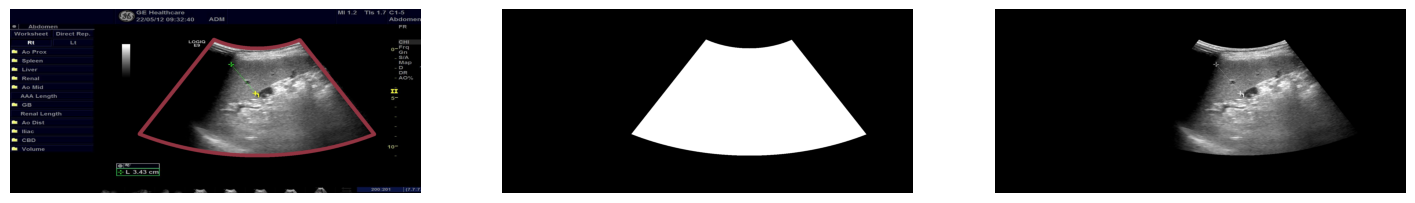

In [18]:
img_mask_plot = cv2.resize(img_mask_fin,(img_raw.shape[1],img_raw.shape[0]),interpolation=cv2.INTER_NEAREST)
contours, hierarchy = cv2.findContours(img_mask_plot,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 
im_raw_plot = img_raw.copy()

plt.figure(figsize = (18,10))
plt.subplot(1,3,1)
plt.axis('off')
cv2.drawContours(im_raw_plot,contours,-1,(66,52,146),15) 
plt.imshow(im_raw_plot[:, :, ::-1],cmap = 'gray')
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(img_mask_plot,cmap = 'gray')
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(cv2.resize(img_fin,(img_raw.shape[1],img_raw.shape[0])),cmap = 'gray')